# Homework 3: Policy methods

**Your task**

- Compare the performance of REINFORCE and REINFORCE with baseline for `CliffWalking`. You can use some of the code of tutorial 6 as inspiration. (4p).

**First things first:** Spend some time getting familiar with the environment.

    The board is a 4x12 matrix, indexed as 1D array:
        0 = top leftt
        11 = top right
        12 = beginning of 2nd row from top at left side
        ...
    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward 
    and a reset to the start. An episode terminates when the agent reaches the goal.
    
    env.step(action) = (new_state, reward_of_this_state, done, probability)

In [1]:
%matplotlib inline
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque

In [6]:
env = gym.make("CliffWalking-v0")
print("Number of states: ", env.observation_space.n)
print("Number of actions: ", env.action_space.n)
print("Result of env.step(0): ", env.step(0))
env.render()
env.close()

Number of states:  48
Number of actions:  4
Result of env.step(0):  (24, -1, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T



In [2]:
def plot_rewards(avg_rewards, title):
    plt.plot(np.array(range(len(avg_rewards)))*100, avg_rewards)
    plt.ylabel('average reward in 100 episodes')
    #plt.ylim(0.2, 1)
    plt.xlabel('episode')
    plt.title(title)

In [107]:
def softmax(x):
    max_x = np.max(x)
    return np.exp(x - max_x) / np.sum(np.exp(x - max_x), axis=0)

class Policy:
    def __init__(self,env, alpha=1e-6, gamma=1, debug=True):
        self.alpha = alpha
        self.gamma = gamma
        self.debug = debug
        self.env = env
        
        self.n_actions = env.action_space.n
        self.n_states = env.observation_space.n
        
        self.possible_actions = range(env.action_space.n)
        self.state_dim = self.featurize(env.reset()).shape[0]
        
        self.w = np.ones(shape=(self.state_dim, self.n_actions), dtype=float) #parameters of the function approximating probabilities of actions
        
        self.last_action_probabilities = np.ones(shape=(self.n_actions,), dtype=float) / self.n_actions
        self.last_action_probabilities = np.tile(self.last_action_probabilities,(self.n_states,1))
    
    def featurize(self,state):
        """
        Turn state + action into feature vector so it can be inputted into the policy function.
        """
        s = np.zeros(shape=(self.n_states,), dtype=float)
        s[state] = 1
        return s
    
    def get_action_probabilities(self, state):
        h = self.featurize(state).dot(self.w).flatten()
        soft = softmax(h)
        if self.debug:
            print("state: {} h: {}".format(state, h))
            print("action_probabilities: ", soft)
        return soft
    
    def gradient(self, state, action):
        """
        See Exercise 13.3 in Barton, Sutton book.
        """
        x_s = self.featurize(state)
        action_probability = self.get_action_probabilities(state)[action]
        
        if self.debug:
            print("x_s=\n", x_s)
            print("action_probability=\n", action_probability)
            
        return x_s - action_probability * x_s
    
    def update(self, episode, max_steps=200):
        """
        Update the parameters by gradient descend.
        
        episode = list of [state, action, reward] over the whole episode
        """
        episode = np.array(episode)
        
        G = []
        for [state, action, reward] in episode[::-1]: # calculate cumulative rewwards till the end from each step
            if len(G) == 0:
                G.append(reward)
            else:
                G.append(reward + G[-1])
        G = G[::-1]
        
        if self.debug:
            print("Episode shape={} whole:\n{}".format(episode.shape, episode))
            print("G: ", G)

        # Update parameters after each step - BUT choose only N random steps otherwise it will run forever.
        if len(episode) <= max_steps:
            chosen_steps = episode
        else:
            chosen_step_indxs = np.random.choice(len(episode), max_steps)
            chosen_steps = episode[chosen_step_indxs]
        
        for t,[state, action, reward] in enumerate(chosen_steps):
            gradient = self.gradient(state, action)
            self.w[:,action] += self.alpha * (np.power(self.gamma,t)) * G[t] * gradient 
            if self.debug:
                print("  t={}  Gradient={}  G[t]={} new_w={}".format(t, gradient, G[t], self.w))
            
        
        for state in range(self.n_states):
            self.last_action_probabilities[state] = self.get_action_probabilities(state)
        
    def choose_action(self,state):
        """
        Calculate numerical prefferences of every action in a given state = h(s,a,w)
        Policy will then calculate action probabilities and sample an action according to them.
        """
        action_probabilities = self.last_action_probabilities[state] # policy is not updated while playing
        return np.random.choice(self.possible_actions, 1, p=action_probabilities)[0]

    
def run_episodes(n_episodes = 1000, gamma = 1,alpha=1e-6, max_update_steps=200, debug=True):
    env = gym.make('CliffWalking-v0')

    policy = Policy(env,alpha=alpha, gamma=gamma, debug=debug)
    episode_rewards = []
    avg_episode_rewards = []

    for ep in range(n_episodes):
        state = env.reset()
        done = False
        ep_reward = 0
        step = 0
        last_fail_step = -1
        episode = []

        while not done:
            action = policy.choose_action(state)
            new_state, reward, done, _ = env.step(action)
            #print("State: {} Action: {} Reward: {}".format(state, action, reward))
            ep_reward += reward

            # Keep track of the states    
            episode.append([state, action, reward])
            
            state = new_state
            
            if debug:
                if reward < -1:
                    break
                    
            if reward == -100:
                if last_fail_step == -1:
                    last_fail_step = step
                else:
                    episode = episode[last_fail_step:]
                
            step += 1
        
        # Update policy
        policy.update(episode, max_steps=max_update_steps)
        #print("done")

        episode_rewards.append(ep_reward)
        # Show stats
        mod = 10
        if (ep) % mod == 0:
            avg_episode_rewards.append(np.average(episode_rewards[-mod:]))
            print("Reward at episode {} is {} | avg in last {}: {}"
                  .format(ep,ep_reward,mod, avg_episode_rewards[-1]))
            
    env.close()
    return episode_rewards, avg_episode_rewards

In [109]:
episode_rewards, avg_episode_rewards = run_episodes(n_episodes = 1000,alpha=1e-10, gamma = 1, max_update_steps=2000, debug=False)

Reward at episode 0 is -46066 | avg in last 10: -46066.0
Reward at episode 10 is -51629 | avg in last 10: -73577.2
Reward at episode 20 is -13417 | avg in last 10: -65922.6
Reward at episode 30 is -11502 | avg in last 10: -66893.7
Reward at episode 40 is -373301 | avg in last 10: -107817.9
Reward at episode 50 is -166140 | avg in last 10: -85611.1
Reward at episode 60 is -90417 | avg in last 10: -77102.0


KeyboardInterrupt: 

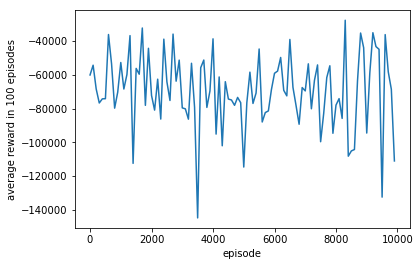

In [104]:
plot_rewards(avg_episode_rewards, "")

In [43]:
np.power(3,2)

9

In [85]:
x = np.zeros(shape=(2,3))
y = np.ones(shape=(2,3))
x[1,2] = 1
x.T.dot(y)

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 1.,  1.,  1.]])